In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
from hyperimpute.plugins.utils.simulate import simulate_nan


def gen_data(df: pd.DataFrame, ratio: float, seed: int = None):
    if seed:
        np.random.seed(seed)   
    vals = df.values
    MAR_result = simulate_nan(vals, ratio, mecha="MAR", p_obs=0.0)
    MCAR_result = simulate_nan(vals, ratio, mecha="MCAR")
    MNAR_result = simulate_nan(vals, ratio, mecha="MNAR", opt="logistic")
    MAR_mask = MAR_result["mask"].astype(bool)
    MCAR_mask = MCAR_result["mask"].astype(bool)
    MNAR_mask = MNAR_result["mask"].astype(bool)
    # fint the col in MAR not exists nan
    for i in range(MAR_mask.shape[1]):
        if not np.any(MAR_mask[:,i]):
            idx = i
    # drop the col in MAR not exists nan
    MAR_mask = np.delete(MAR_mask, idx, axis=1)
    MCAR_mask = np.delete(MCAR_mask, idx, axis=1)
    MNAR_mask = np.delete(MNAR_mask, idx, axis=1)
    return MAR_mask, MCAR_mask, MNAR_mask

def get_points(mask: np.ndarray):
    points = []
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            if mask[j, i]:
                points.append([i, j])
    return points

714 713 748


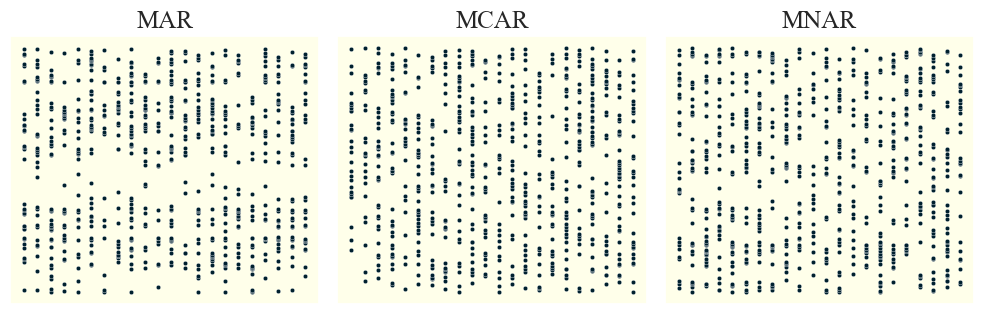

In [19]:
df = pd.read_csv("dataset/PUE.csv")
# select the numeric columns
df = df.select_dtypes(include=[np.number])

MAR_mask, MCAR_mask, MNAR_mask = gen_data(df.copy(), 0.1)
MAR_points = get_points(MAR_mask)
MCAR_points = get_points(MCAR_mask)
MNAR_points = get_points(MNAR_mask)

# plot mask as image

# cmap = sns.color_palette(["#F8F4E1", "#30353E"])
sns.set_theme(font="Times New Roman")
fig, ax = plt.subplots(1, 3, figsize=(10, 3.3))
# set ax background color
ax[0].set_facecolor("#ffffea")
ax[1].set_facecolor("#ffffea")
ax[2].set_facecolor("#ffffea")
sns.scatterplot(x=[i[0] for i in MAR_points], y=[i[1] for i in MAR_points], ax=ax[0], s=10, color="#00202e")
sns.scatterplot(x=[i[0] for i in MCAR_points], y=[i[1] for i in MCAR_points], ax=ax[1], s=10, color="#00202e")
sns.scatterplot(x=[i[0] for i in MNAR_points], y=[i[1] for i in MNAR_points], ax=ax[2], s=10, color="#00202e")
print(MAR_mask.sum(), MCAR_mask.sum(), MNAR_mask.sum())
ax[0].set_title("MAR", fontsize=18)
# del xtick and ytick
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title("MCAR", fontsize=18)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].set_title("MNAR", fontsize=18)
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()
plt.savefig("results/mask.png", dpi=300)

In [63]:
import math
# Radial Distribution Function
from collections import defaultdict


def distance_2d(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def is_same_point(x1, y1, x2, y2):
    return x1 == x2 and y1 == y2


# def radial_distribution_2d_at_point(masks, idx_i, idx_j):
#     m, n = masks.shape
#     cnt = defaultdict(int)
#     for k in range(m):
#         for l in range(n):
#             if masks[k, l] and not is_same_point(idx_i, idx_j, k, l):
#                 distance = distance_2d(idx_i, idx_j, k, l)
#                 cnt[distance] += 1

#     r = math.ceil(math.sqrt(m ** 2 + n ** 2))
#     N = masks.sum()
#     rho_total = N / (math.pi * r ** 2)
#     dr = 1
#     g_r = {}
#     for ii in range(r):
#         r_i = ii
#         s_i = 2 * math.pi * r_i * dr
#         if s_i == 0:
#             g_r[r_i] = 0
#         else:
#             N_i = 0
#             for k, v in cnt.items():
#                 if r_i <= k < r_i + dr:
#                     N_i += v
#             g_r[r_i] = N_i / (rho_total * N * s_i)
#     return g_r


# def radial_distribution_2d(masks):
#     m, n = masks.shape
#     avg_g_r = defaultdict(float)
#     N = masks.sum()
#     print(N)
#     for i in range(m):
#         for j in range(n):
#             if masks[i, j]:
#                 g_r = radial_distribution_2d_at_point(masks, i, j)
#                 for k, v in g_r.items():
#                     if k not in avg_g_r:
#                         avg_g_r[k] = 0
#                     avg_g_r[k] += v
#     for k, v in avg_g_r.items():
#         avg_g_r[k] = v / N
#     return avg_g_r


def rdf_2d(mask, dr=1):
    n, m = mask.shape
    cnt = defaultdict(int)
    for i in range(n):
        for j in range(m):
            for di in range(1, n):
                for dj in range(1, m):
                    r2 = di ** 2 + dj ** 2
                    ni = i + di if i + di < n else i + di - n
                    nj = j + dj if j + dj < m else j + dj - m
                    if mask[i, j] and mask[ni, nj]:
                        cnt[r2] += 1
    max_r = math.ceil(math.sqrt(m ** 2 + n ** 2))
    N = mask.sum()
    rho_total = N / (0.25 * math.pi * max_r ** 2)
    g_r = {}
    for ii in range(0, max_r - 1, dr):
        r_i = ii
        s_i = 0.5 * math.pi * r_i * dr if r_i != dr else 0.25 * math.pi * dr ** 2
        if s_i == 0:
            g_r[r_i] = 0
        else:
            N_i = 0
            for k, v in cnt.items():
                if r_i - dr <= math.sqrt(k) < r_i:
                    N_i += v
            g_r[r_i] = N_i / (rho_total * N * s_i)
    for k, v in g_r.items():
        g_r[k] = v / N
    return g_r


def avg_dict(d: defaultdict, n: int):
    for k, v in d.items():
        d[k] = v / n
    return d

In [5]:
def dict_add(a: defaultdict, b: dict):
    for k in b.keys():
        a[k] += b[k]
    return a

C:\Users\11946\AppData\Local\Temp\ipykernel_17392\181928268.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


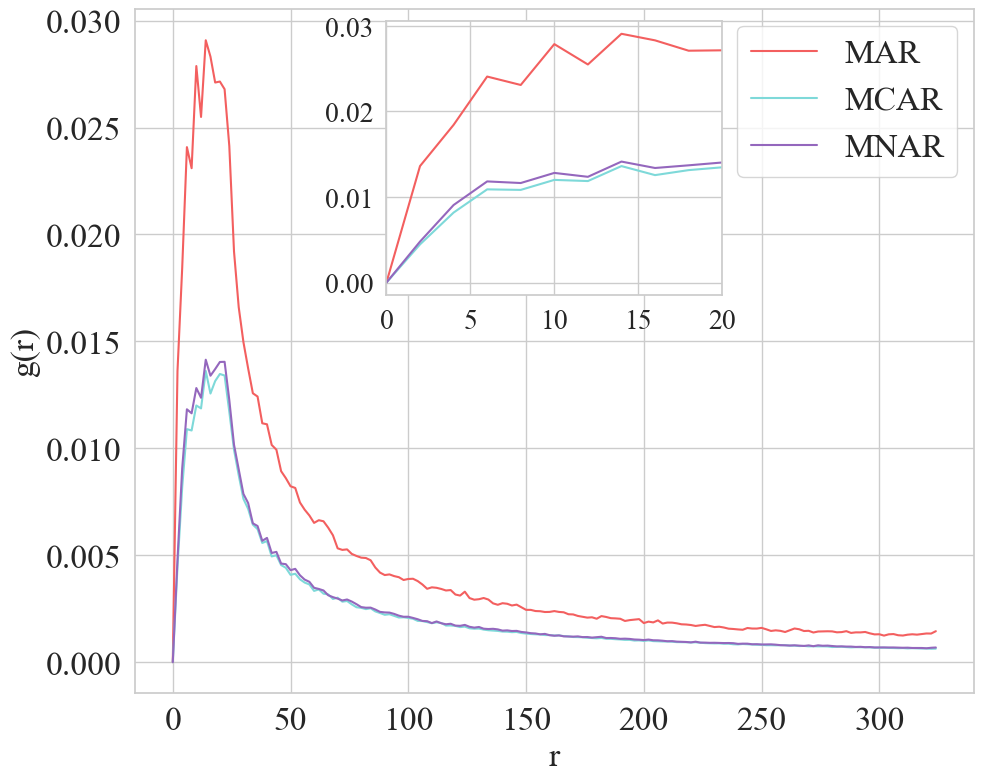

In [6]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = pd.read_csv("dataset/PUE.csv")
# select the numeric columns
df = df.select_dtypes(include=[np.number])

sns.set_theme(style="whitegrid", font="Times New Roman")
fig, ax = plt.subplots(figsize=(10, 8))

MAR_rdf = defaultdict(float)
MCAR_rdf = defaultdict(float)
MNAR_rdf = defaultdict(float)
n = 3
dr = 2
for _ in range(n):
    MAR_mask, MCAR_mask, MNAR_mask = gen_data(df.copy(), 0.1)

    MAR_rdf_i = rdf_2d(MAR_mask, dr=dr)
    MCAR_rdf_i = rdf_2d(MCAR_mask, dr=dr)
    MNAR_rdf_i = rdf_2d(MNAR_mask, dr=dr)
    MAR_rdf = dict_add(MAR_rdf, MAR_rdf_i)
    MCAR_rdf = dict_add(MCAR_rdf, MCAR_rdf_i)
    MNAR_rdf = dict_add(MNAR_rdf, MNAR_rdf_i)

MAR_rdf = avg_dict(MAR_rdf, n)
MCAR_rdf = avg_dict(MCAR_rdf, n)
MNAR_rdf = avg_dict(MNAR_rdf, n)

sns.lineplot(x=list(MAR_rdf.keys()), y=list(MAR_rdf.values()), label="MAR", ax=ax, color="#F35F5F", linewidth=1.5)
sns.lineplot(x=list(MCAR_rdf.keys()), y=list(MCAR_rdf.values()), label="MCAR", ax=ax, color="#7ED9D9", linewidth=1.5)
sns.lineplot(x=list(MNAR_rdf.keys()), y=list(MNAR_rdf.values()), label="MNAR", ax=ax, color="#9467BD", linewidth=1.5)
axins = inset_axes(ax, width="40%", height="40%", loc="upper center",borderpad = 0.8)
sns.lineplot(x=list(MAR_rdf.keys()), y=list(MAR_rdf.values()), label="MAR", ax=axins, color="#F35F5F", linewidth=1.5)
sns.lineplot(x=list(MCAR_rdf.keys()), y=list(MCAR_rdf.values()), label="MCAR", ax=axins, color="#7ED9D9", linewidth=1.5)
sns.lineplot(x=list(MNAR_rdf.keys()), y=list(MNAR_rdf.values()), label="MNAR", ax=axins, color="#9467BD", linewidth=1.5)
# set x limit
axins.set_xlim(0, 20)
# del legend
axins.get_legend().remove()
axins.tick_params(labelsize=20)

ax.set_xlabel("r", fontsize=24)
ax.set_ylabel("g(r)", fontsize=24)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24)
plt.tight_layout()
plt.savefig("results/rdf-3type.png", dpi=300)
plt.show()

C:\Users\11946\AppData\Local\Temp\ipykernel_17392\1588194623.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


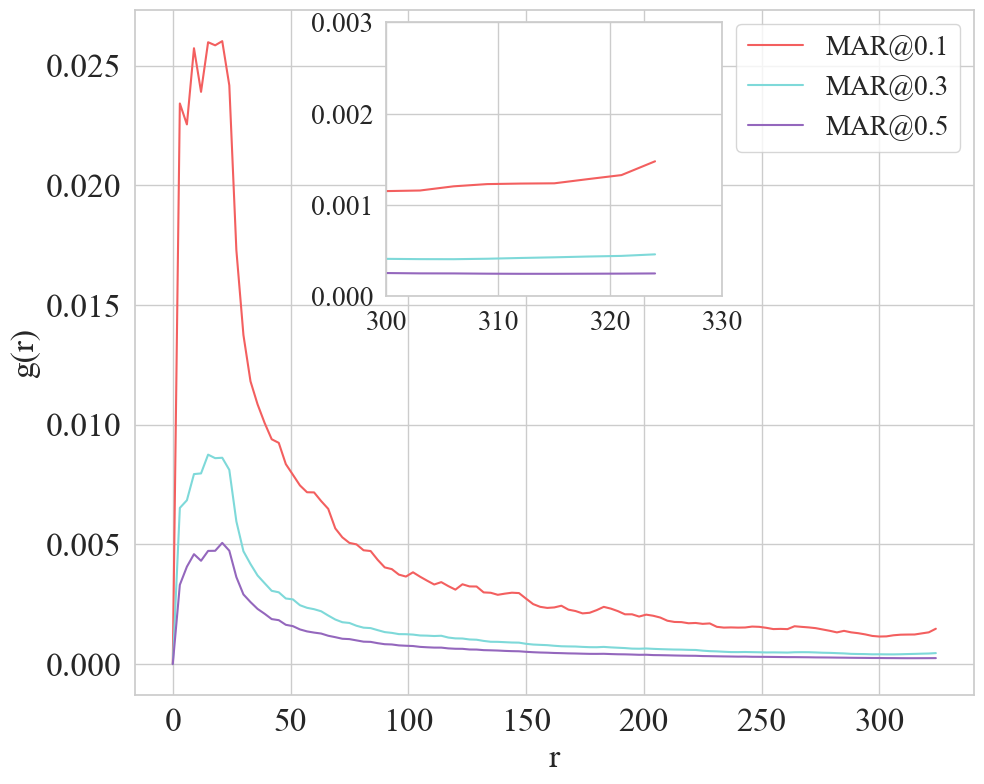

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = pd.read_csv("dataset/PUE.csv")
# select the numeric columns
df = df.select_dtypes(include=[np.number])

sns.set_theme(style="whitegrid", font="Times New Roman")
fig, ax = plt.subplots(figsize=(10, 8))
n = 3
dr = 3
colors = ["#F35F5F", "#7ED9D9", "#9467BD"]
axins = inset_axes(ax, width="40%", height="40%", loc="upper center", borderpad = 0.8)
for idx,i in enumerate([1, 3, 5]):
    color = colors[idx]
    all_rdf = defaultdict(float)
    for _ in range(n):
        MAR_mask, _, _ = gen_data(df.copy(), i / 10)
        MAR_rdf = rdf_2d(MAR_mask, dr=dr)
        all_rdf = dict_add(all_rdf, MAR_rdf)
    all_rdf = avg_dict(all_rdf, n)
    sns.lineplot(x=list(all_rdf.keys()), y=list(all_rdf.values()), label=f"MAR@{i / 10}", ax=ax, linewidth=1.5,color=color)
    sns.lineplot(x=list(all_rdf.keys()), y=list(all_rdf.values()), label=f"MAR@{i / 10}", ax=axins, linewidth=1.5, color=color)
# set x limit
axins.set_xlim(300, 330)
axins.set_ylim(0, 0.003)
axins.tick_params(labelsize=20)

# del legend
axins.get_legend().remove()
ax.set_xlabel("r", fontsize=24)
ax.set_ylabel("g(r)", fontsize=24)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig("results/rdf-PUE.png", dpi=300)

C:\Users\11946\AppData\Local\Temp\ipykernel_17392\2684136738.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


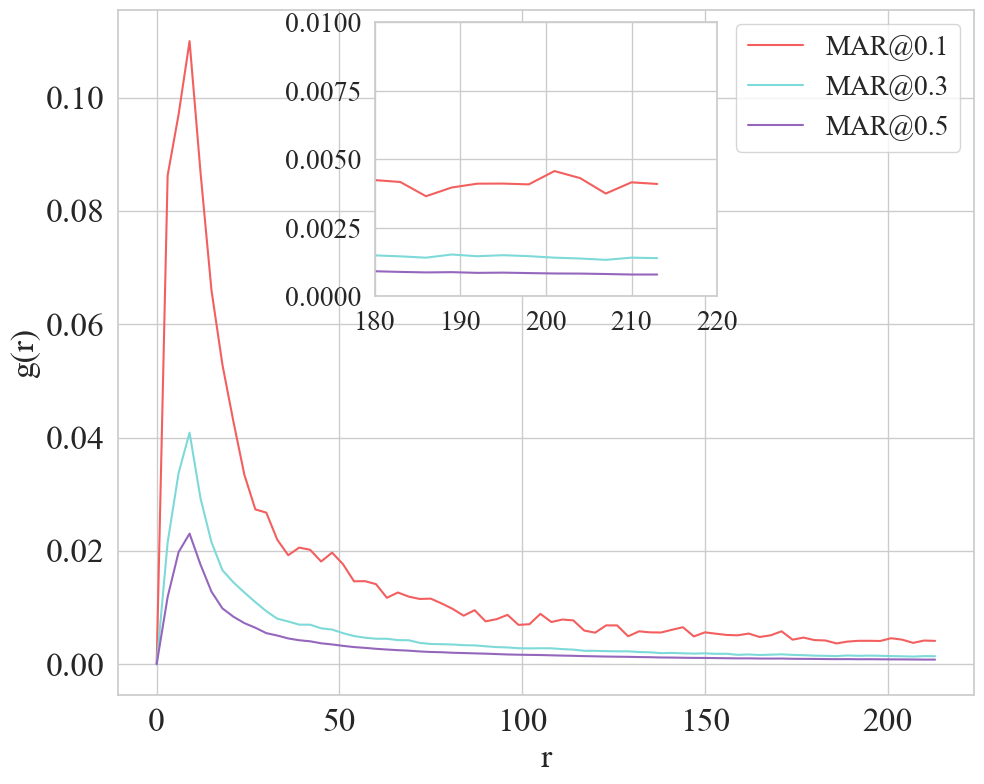

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = pd.read_csv("dataset/glass.csv")
df = df.select_dtypes(include=[np.number])

sns.set_theme(style="whitegrid", font="Times New Roman")
fig, ax = plt.subplots(figsize=(10, 8))
n = 3
dr = 3

colors = ["#F35F5F", "#7ED9D9", "#9467BD"]

axins = inset_axes(ax, width="40%", height="40%", loc="upper center", borderpad = 0.8)
for idx,i in enumerate([1, 3, 5]):
    color = colors[idx]
    all_rdf = defaultdict(float)
    for _ in range(n):
        np.random.seed(853818)
        MAR_result = simulate_nan(df.copy().values, i / 10, mecha="MAR")
        MAR_mask = MAR_result["mask"].astype(bool)
        MAR_rdf = rdf_2d(MAR_mask, dr=dr)
        all_rdf = dict_add(all_rdf, MAR_rdf)
    all_rdf = avg_dict(all_rdf, n)
    sns.lineplot(x=list(all_rdf.keys()), y=list(all_rdf.values()), label=f"MAR@{i / 10}", ax=ax, linewidth=1.5,color=color)
    sns.lineplot(x=list(all_rdf.keys()), y=list(all_rdf.values()), label=f"MAR@{i / 10}", ax=axins, linewidth=1.5, color=color)
# set x limit
axins.set_xlim(180, 220)
axins.set_ylim(0, 0.01)
axins.tick_params(labelsize=20)

# del legend
axins.get_legend().remove()
ax.set_xlabel("r", fontsize=24)
ax.set_ylabel("g(r)", fontsize=24)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig("results/rdf-glass.png", dpi=300)

In [9]:
# -*- coding: utf-8 -*-
"""
Python implemention of PPCA-EM for data with missing values
Adapted from MATLAB implemention from J.J. VerBeek
Modifications made in order to support high-dimensional matrices

Sheridan Beckwith Green
sheridan.green@yale.edu
Sept 2018

Updates by Ludvig Hult in 2019
"""

import numpy as np
from numpy import shape, isnan, nanmean, average, log, cov
from numpy.matlib import repmat
from numpy.random import normal
from numpy.linalg import inv, det, eig
from numpy import identity as eye
from numpy import trace as tr
from scipy.linalg import orth


def ppca(Y, d, dia):
    """
    Implements probabilistic PCA for data with missing values,
    using a factorizing distribution over hidden states and hidden observations.

    Args:
        Y:   (N by D ) input numpy ndarray of data vectors
        d:   (  int  ) dimension of latent space
        dia: (boolean) if True: print objective each step

    Returns:
        C:  (D by d ) C*C' + I*ss is covariance model, C has scaled principal directions as cols
        ss: ( float ) isotropic variance outside subspace
        M:  (D by 1 ) data mean
        X:  (N by d ) expected states
        Ye: (N by D ) expected complete observations (differs from Y if data is missing)

        Based on MATLAB code from J.J. VerBeek, 2006. http://lear.inrialpes.fr/~verbeek
    """
    N, D = shape(Y)  # N observations in D dimensions (i.e. D is number of features, N is samples)
    threshold = 1E-4  # minimal relative change in objective function to continue
    hidden = isnan(Y)
    missing = hidden.sum()

    if missing > 0:
        M = nanmean(Y, axis=0)
    else:
        M = average(Y, axis=0)

    Ye = Y - repmat(M, N, 1)

    if missing > 0:
        Ye[hidden] = 0

    # initialize
    C = normal(loc=0.0, scale=1.0, size=(D, d))
    CtC = C.T @ C
    X = Ye @ C @ inv(CtC)
    recon = X @ C.T
    recon[hidden] = 0
    ss = np.sum((recon - Ye) ** 2) / (N * D - missing)

    count = 1
    old = np.inf

    # EM Iterations
    while (count):
        Sx = inv(eye(d) + CtC / ss)  # E-step, covariances
        ss_old = ss
        if missing > 0:
            proj = X @ C.T
            Ye[hidden] = proj[hidden]

        X = Ye @ C @ Sx / ss  # E-step: expected values

        SumXtX = X.T @ X  # M-step
        C = Ye.T @ X @ (SumXtX + N * Sx).T @ inv(((SumXtX + N * Sx) @ (SumXtX + N * Sx).T))
        CtC = C.T @ C
        ss = (np.sum((X @ C.T - Ye) ** 2) + N * np.sum(CtC * Sx) + missing * ss_old) / (N * D)
        # transform Sx determinant into numpy longdouble in order to deal with high dimensionality
        Sx_det = np.min(Sx).astype(np.longdouble) ** shape(Sx)[0] * det(Sx / np.min(Sx))
        objective = N * D + N * (D * log(ss) + tr(Sx) - log(Sx_det)) + tr(SumXtX) - missing * log(ss_old)

        rel_ch = np.abs(1 - objective / old)
        old = objective

        count = count + 1
        if rel_ch < threshold and count > 5:
            count = 0
        if dia:
            print(f"Objective: {objective:.2f}, Relative Change {rel_ch:.5f}")

    C = orth(C)
    covM = cov((Ye @ C).T)
    vals, vecs = eig(covM)
    ordr = np.argsort(vals)[::-1]
    vecs = vecs[:, ordr]

    C = C @ vecs
    X = Ye @ C

    # add data mean to expected complete data
    Ye = Ye + repmat(M, N, 1)

    return C, ss, M, X, Ye

In [10]:
def plot_pca(X, mask, title, ax):
    res = ppca(X, 2, False)
    X = res[3]

    # get the row exist null value index
    mask = mask.astype(int)
    mask = mask.sum(axis=1)
    mask_without_null = mask == 0
    mask_low_null = (mask >= 1) & (mask <= 2)
    mask_hight_null = mask > 2
    sns.scatterplot(x=X[mask_low_null][:, 0], y=X[mask_low_null][:, 1], label="1<= Missing Features <=2", ax=ax)
    sns.scatterplot(x=X[mask_hight_null][:, 0], y=X[mask_hight_null][:, 1], label="Missing Features >=3", ax=ax)
    sns.scatterplot(x=X[mask_without_null][:, 0], y=X[mask_without_null][:, 1], label="Observed", ax=ax)
    ax.tick_params(labelsize=20)
    ax.set_title(title, fontsize=24)


# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# plot_pca(MAR_result["X_incomp"], MAR_mask, "MAR", axes[0])
# plot_pca(MCAR_result["X_incomp"], MCAR_mask, "MCAR", axes[1])
# plot_pca(MNAR_result["X_incomp"], MNAR_mask, "MNAR", axes[2])
# fig.tight_layout()

In [11]:
# df = pd.read_csv("dataset/Bala_regression_dataset.csv")
# # select the numeric columns
# df = df.select_dtypes(include=[np.number])

In [12]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [13]:
# df_missing = df.copy()
# df_missing

In [14]:
# # randomly select 10% of the one col in data to be missing
# for col in df_missing.columns:
#     df_missing.loc[df_missing.sample(frac=0.1).index, col] = np.nan

# df_missing.drop(["Ferroelectric_Tc_in_Kelvin"], axis=1, inplace=True)
# df_missing

In [15]:
# from sklearn.impute import KNNImputer, SimpleImputer
# from matplotlib import pyplot as plt
# import seaborn as sns

# mean_imputer = SimpleImputer(strategy="mean")
# knn_imputer = KNNImputer()

# df_impute_with_knn = knn_imputer.fit_transform(df_missing)
# df_impute_with_knn = pd.DataFrame(df_impute_with_knn, columns=df_missing.columns)

# df_impute_with_mean = mean_imputer.fit_transform(df_missing)
# df_impute_with_mean = pd.DataFrame(df_impute_with_mean, columns=df_missing.columns)

In [16]:
# #plot original data and imputed data
# plt.rcParams["font.family"] = "times new roman"

# fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# axes = axes.flatten()

# for i, col in enumerate(df_missing.columns):
#     sns.kdeplot(df[col], ax=axes[i], label="Original", color="#F35F5F")
#     sns.kdeplot(df_impute_with_knn[col], ax=axes[i], label="KNN", color="#7ED9D9")
#     sns.kdeplot(df_impute_with_mean[col], ax=axes[i], label="Mean", color="#9467BD")
#     axes[i].tick_params(labelsize=20)
#     # x label size
#     axes[i].set_xlabel(col, fontsize=20)
#     # y label size
#     axes[i].set_ylabel("Density", fontsize=20)

# # legend all in one
# axes[0].legend(fontsize=20)
# plt.tight_layout()
# plt.savefig("results/diff.png", dpi=300)

In [17]:
seeds = []
while len(seeds) <= 5:
    seed = np.random.randint(1, 100)
    np.random.seed(seed=seed)
    try:
        MAR_result = simulate_nan(df.copy().values, 0.5, mecha="MAR")
        MAR_mask = MAR_result["mask"].astype(bool)
        MAR_rdf = rdf_2d(MAR_mask, dr=dr)
        all_rdf = dict_add(all_rdf, MAR_rdf)
        seeds.append(seed)
    except:
        continue


In [18]:
seeds

[64, 63, 15, 19, 32, 97]

In [19]:
[674435, 853818, 837854, 943219, 968918, 169652]
[674435, 853818, 837854, 943219, 968918, 169652]
[573051, 308775, 777094, 48708, 734654, 27049]

[573051, 308775, 777094, 48708, 734654, 27049]